In [1]:
# Import TensorFlow and TensorFlow Datasets
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tfds.disable_progress_bar()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
datasets , info = tfds.load(name = 'beans', with_info = True, as_supervised = True, split = ['train', 'test', 'validation'])

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteP1LLEL/beans-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteP1LLEL/beans-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteP1LLEL/beans-test.tfrecord
Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [ ]:
datasets

[<PrefetchDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>,
 <PrefetchDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>,
 <PrefetchDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>]

In [ ]:
train, info_train = tfds.load(name = 'beans', with_info = True, split = 'test')

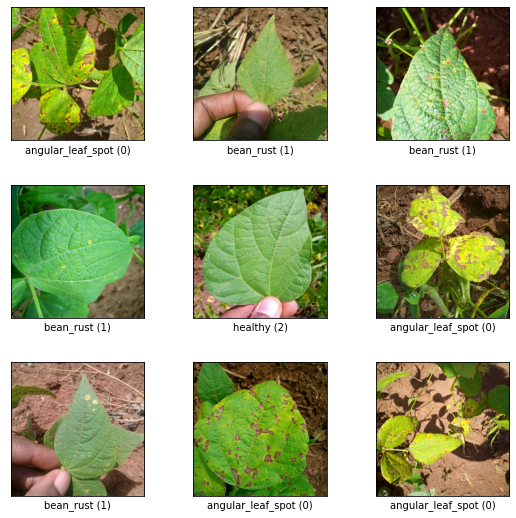

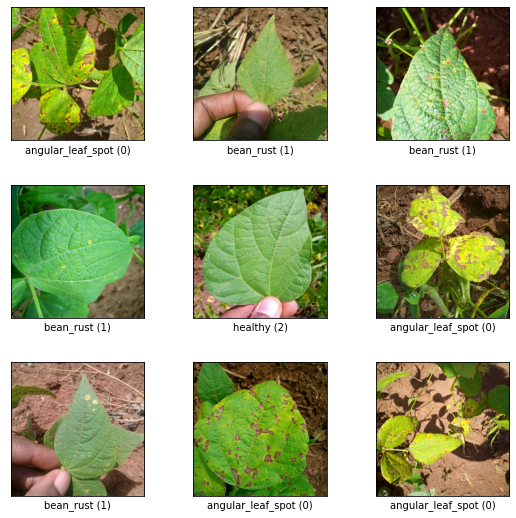

In [ ]:
tfds.show_examples(train, info_train)

In [ ]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    
    return tf.image.resize(image, [224, 224]), tf.one_hot(label, 3)

In [ ]:
def get_dataset(batch_size = 32):
    train_dataset_sclaed = datasets[0].map(scale).shuffle(1000).batch(batch_size)
    test_dataset_sclaed = datasets[1].map(scale).batch(batch_size)
    validation_dataset_sclaed = datasets[2].map(scale).batch(batch_size)
    
    return train_dataset_sclaed, test_dataset_sclaed, validation_dataset_sclaed
    

In [ ]:
train_dataset, test_dataset, val_dataset = get_dataset()

train_dataset.cache()
val_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [ ]:
len(list(datasets[0]))

1034

In [ ]:
feature_extractor = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape = (224, 224, 3))

In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential(
    [
        feature_extractor_layer,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(3, activation = 'softmax')
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc']
)

In [ ]:
hist = model.fit(train_dataset, epochs = 6, validation_data = val_dataset)

Epoch 1/6
33/33 [==============================] - 45s 1s/step - loss: 0.9933 - acc: 0.5306 - val_loss: 0.5445 - val_acc: 0.7444
Epoch 2/6
33/33 [==============================] - 39s 1s/step - loss: 0.5692 - acc: 0.7610 - val_loss: 0.4044 - val_acc: 0.8271
Epoch 3/6
33/33 [==============================] - 40s 1s/step - loss: 0.4676 - acc: 0.8129 - val_loss: 0.3774 - val_acc: 0.8421
Epoch 4/6
33/33 [==============================] - 40s 1s/step - loss: 0.3805 - acc: 0.8689 - val_loss: 0.3264 - val_acc: 0.8797
Epoch 5/6
33/33 [==============================] - 40s 1s/step - loss: 0.3322 - acc: 0.8792 - val_loss: 0.3174 - val_acc: 0.8571
Epoch 6/6
33/33 [==============================] - 40s 1s/step - loss: 0.3572 - acc: 0.8690 - val_loss: 0.2966 - val_acc: 0.9173


In [ ]:
result = model.evaluate(test_dataset)

4/4 [==============================] - 5s 1s/step - loss: 0.2842 - acc: 0.8906


[[8.4268880e-01 1.5691669e-01 3.9447445e-04]]


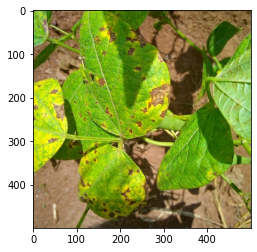

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot
[[0.01756708 0.97449815 0.00793475]]


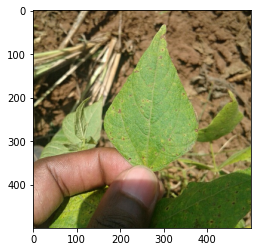

Actual Label : bean_rust
Predicted Label : bean_rust
[[0.33453515 0.5269432  0.13852157]]


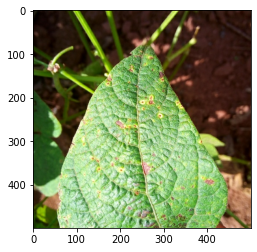

Actual Label : bean_rust
Predicted Label : bean_rust
[[0.03859394 0.25645953 0.70494646]]


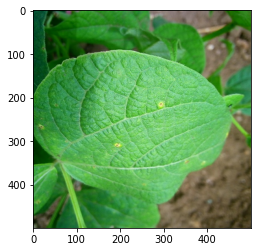

Actual Label : bean_rust
Predicted Label : healthy
[[0.00233728 0.00970309 0.9879596 ]]


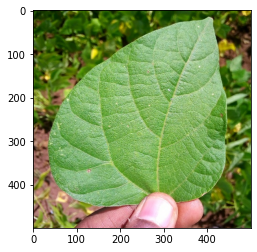

Actual Label : healthy
Predicted Label : healthy
[[0.71433294 0.27835461 0.00731242]]


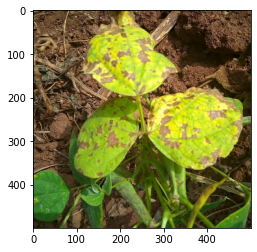

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot
[[0.00720145 0.95097333 0.04182516]]


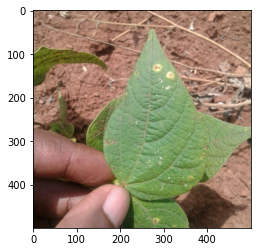

Actual Label : bean_rust
Predicted Label : bean_rust
[[0.9694568  0.02755712 0.00298604]]


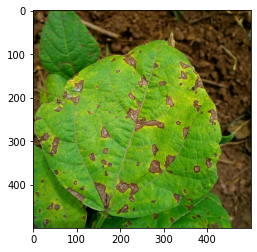

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot
[[0.778541   0.22018301 0.00127599]]


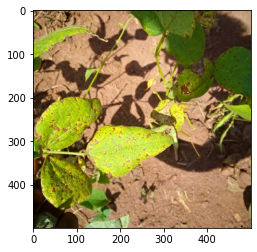

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot
[[0.03845858 0.82103175 0.14050972]]


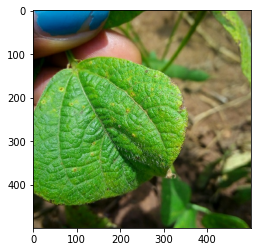

Actual Label : bean_rust
Predicted Label : bean_rust


In [ ]:
for test_sample in datasets[1].take(10):
    image, label = test_sample[0], test_sample[1]
    image_scaled, label_arr = scale(test_sample[0], test_sample[1])
    image_scaled = np.expand_dims(image_scaled, axis = 0)
    
    img = tf.keras.preprocessing.image.img_to_array(image)
    
    pred = model.predict(image_scaled)
    
    print(pred)
    
    plt.figure()
    plt.imshow(image)
    plt.show()
    
    print("Actual Label : %s" %info.features['label'].names[label.numpy()])
    print("Predicted Label : %s" %info.features['label'].names[np.argmax(pred)])
    

In [ ]:
for f0, f1 in datasets[1].map(scale).batch(200):
    y = np.argmax(f1, axis = 1)
    y_pred = np.argmax(model.predict(f0), axis = 1)
    
    print(tf.math.confusion_matrix(labels = y, predictions = y_pred, num_classes = 3))

tf.Tensor(
[[40  3  0]
 [ 6 36  1]
 [ 0  4 38]], shape=(3, 3), dtype=int32)


In [ ]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name = 'beans', 
    split = ['train', 'validation', 'test'],
    as_supervised = True,
    with_info = True)

In [ ]:
# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)

def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label

ds_train = ds_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_validation = ds_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.batch(batch_size)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
from collections import Counter
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(ds_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(ds_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(ds_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


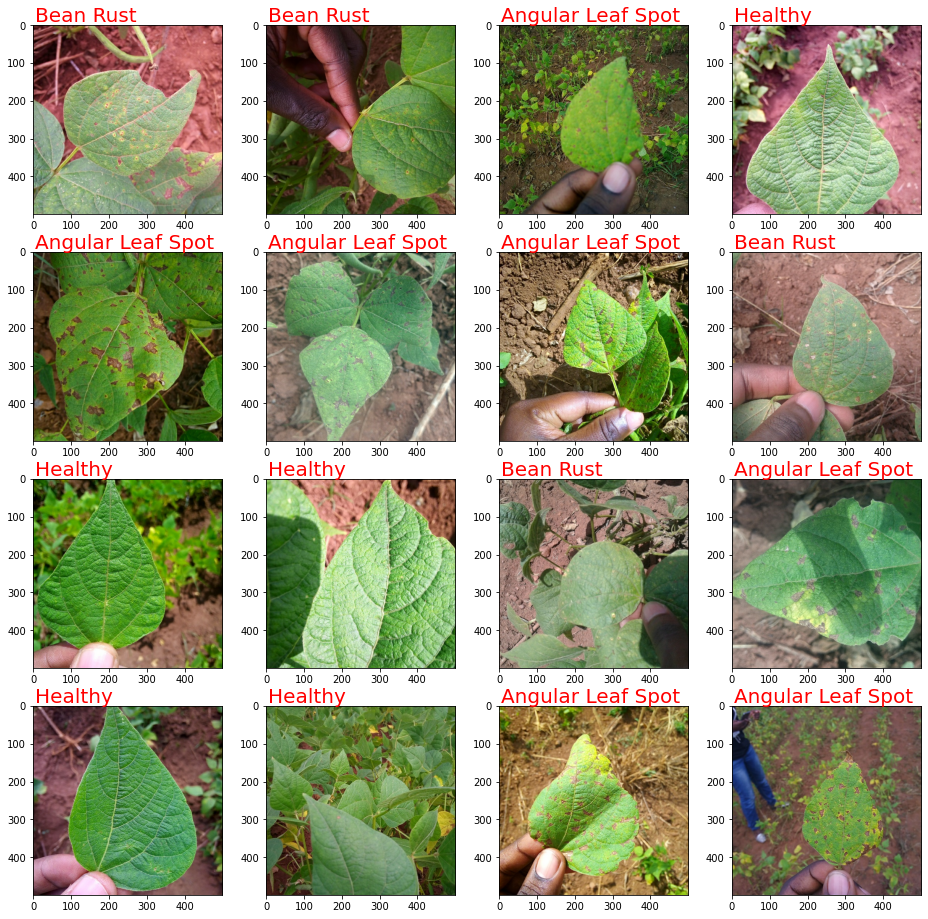

In [ ]:
example = ds_train.take(1)
for sample in example:
    image, label = sample[0], sample[1]
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))  

In [ ]:
#Download the dataset and divide it into train and test
datasets, info = tfds.load('beans', with_info=True, as_supervised=True)
beans_train, beans_test = datasets['train'], datasets['test']

In [ ]:
#Initializing the distributed learning algorithm
strategy = tf.distribute.MirroredStrategy()

#Defining some necessary hyperparamters
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

train_dataset = beans_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = beans_test.map(scale).batch(BATCH_SIZE)

In [ ]:
#Make CNN using the distributed learning algorithm
with strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(500, 500, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Function for decaying the learning rate.
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5
  
 # Define the callbacks
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay)
]
  
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy())) 

In [ ]:
import time

start = time.time()
model.fit(train_dataset, epochs=7, callbacks=callbacks)
end = time.time()
print("Time elapsed: {}".format(end-start))

Epoch 1/7
33/33 [==============================] - 202s 6s/step - loss: 3.5626 - accuracy: 0.4226
Epoch 2/7
33/33 [==============================] - 193s 6s/step - loss: 0.7637 - accuracy: 0.6607
Epoch 3/7
33/33 [==============================] - 193s 6s/step - loss: 0.6308 - accuracy: 0.7383
Epoch 4/7
33/33 [==============================] - 193s 6s/step - loss: 0.5027 - accuracy: 0.7909
Epoch 5/7
33/33 [==============================] - 193s 6s/step - loss: 0.4501 - accuracy: 0.8246
Epoch 6/7
33/33 [==============================] - 193s 6s/step - loss: 0.4052 - accuracy: 0.8484
Epoch 7/7
33/33 [==============================] - 194s 6s/step - loss: 0.3712 - accuracy: 0.8708
Time elapsed: 1365.1580715179443
